# Semantic Data Specialist Tech Demo
William Reed Quinn<br>
Semantic Data Specialist, Northeastern University<br>
July 8, 2020

Works Cited:

"[Library of Congress Data Exploration](https://github.com/LibraryOfCongress/data-exploration/blob/master/ChronAm%20API%20Samples.ipynb)"

In [15]:
import requests, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from scipy import stats
import spacy
from spacy import displacy
nlp = spacy.load('en')

In [8]:
%%time

search_term = "election"

pages_of_results = 10

st_df = pd.DataFrame(columns = ['state', 'year'])

for page in range(0, pages_of_results):
    st_json = requests \
        .get("http://chroniclingamerica.loc.gov/search/pages/results/?proxtext=" + \
             search_term + "&format=json&page=" + str(page)).json()
    
    for item in st_json['items']:
        state = item['state'][0]
        year = pd.to_datetime(item['date'], format="%Y%m%d").year
        
        st_df = st_df.append({'state':state,
                              'year':year},
                             ignore_index=True) 

st_df.head()

CPU times: user 1.02 s, sys: 62.1 ms, total: 1.09 s
Wall time: 4.64 s


,state,year
0,Missouri,1909
1,Montana,1912
2,Missouri,1915
3,Missouri,1909
4,North Dakota,1906


## Occurence of Search Term by State

In [9]:
%%time

print (min(st_df['year']), max(st_df['year']))

counts = st_df \
    .groupby(['state']) \
    .size().to_frame('count') \
    .sort_values(['count'], ascending=False) \
    .reset_index()

counts.head()

1870 1944
CPU times: user 5.46 ms, sys: 484 µs, total: 5.94 ms
Wall time: 5.57 ms


,state,count
0,New York,33
1,Missouri,23
2,North Dakota,23
3,Arizona,17
4,Montana,16


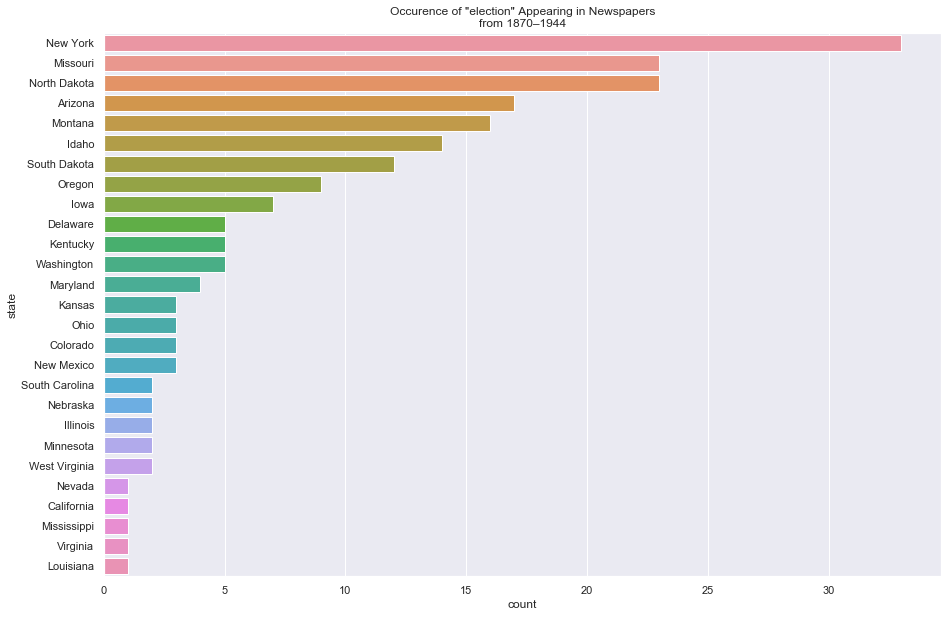

In [162]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_palette("Paired")

ax = sns.barplot(data = counts,
                  x = 'count', y = 'state') \
    .set_title('Occurence of "' + search_term + '" Appearing in Newspapers\nfrom ' + \
               str(min(st_df['year'])) + '–' + str(max(st_df['year'])))

## Term Frequency by Year in Specified State

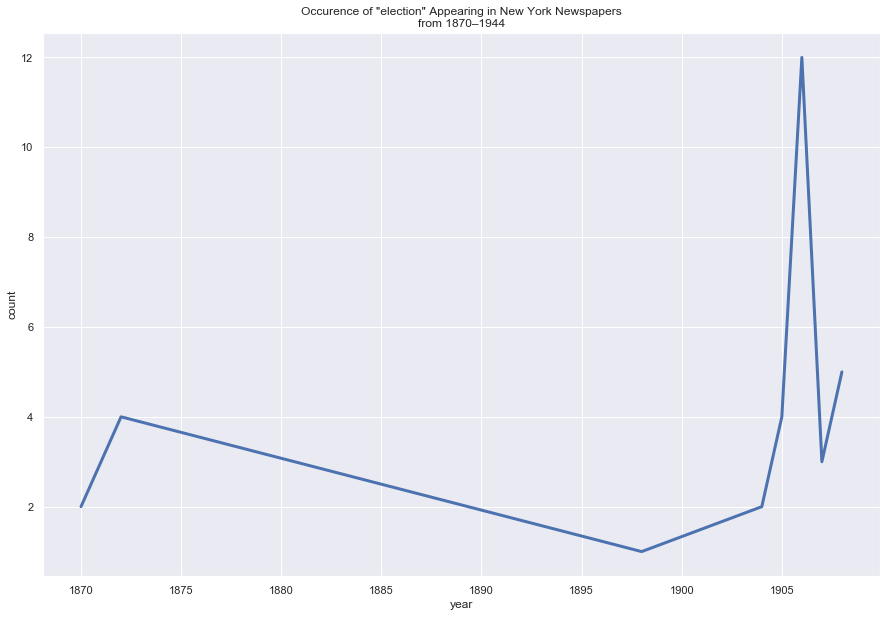

In [161]:
specified_state = "New York"

term_freq = st_df \
    .query('state == @specified_state') \
    .groupby(['year']) \
    .size().to_frame('count') \
    .sort_values(['year'], ascending=True) \
    .reset_index()

ax = sns.lineplot(data = term_freq, x = "year", y = "count", linewidth = 3) \
    .set_title('Occurence of "' + search_term + '" Appearing in ' + specified_state + \
               ' Newspapers\nfrom ' + str(min(st_df['year'])) + '–' + str(max(st_df['year'])))

## Named Entity Recognition 

In [78]:
%%time

pages_of_results = 2

ner_df = pd.DataFrame()
ner_df = pd.DataFrame(columns = ['state', 'year'])

for page in range(0, pages_of_results):
    st_json = requests \
        .get("http://chroniclingamerica.loc.gov/search/pages/results/?proxtext=" + \
             search_term + "&format=json&page=" + str(page)).json()
    
    for item in st_json['items']:
        state = item['state'][0]
        year = pd.to_datetime(item['date'], format="%Y%m%d").year
        
        clean_text = re.sub(r'\W', ' ', item['ocr_eng'])

        doc = nlp(clean_text)
        count = Counter([(x.text, x.label_) for x in doc.ents])

        doc_df = pd.DataFrame({'state':state,
                               'year':year,
                               'count':count}) \
            .reset_index()

        ner_df = pd.concat([ner_df, doc_df], sort=False)

ner_df = ner_df.reset_index()
ner_df.columns = ['index', 'state', 'year', 'entity', 'label', 'count']
ner_df = ner_df[['state', 'year', 'entity', 'label', 'count']]

ner_df['entity'] = ner_df['entity'].replace(r'\s+', np.nan, regex=True)

ner_df = ner_df.dropna(how="any", axis=0)

ner_df.head()

CPU times: user 1min 7s, sys: 16.9 s, total: 1min 24s
Wall time: 48.7 s


,state,year,entity,label,count
41,Missouri,1909,0,CARDINAL,3.0
42,Missouri,1909,00,CARDINAL,3.0
43,Missouri,1909,1,CARDINAL,33.0
53,Missouri,1909,104,ORG,1.0
56,Missouri,1909,166,CARDINAL,1.0


In [80]:
ner_counts = ner_df.groupby(['state', 'label', 'entity'])['count'].sum() \
    .reset_index()

ner_counts \
    .query('label != "CARDINAL"') \
    .sort_values(by = ['count'], ascending = False).groupby(['state']).head(1)

,state,label,entity,count
1457,Missouri,PERSON,Boyer,88.0
2755,New York,ORG,Inspectors,88.0
2337,Montana,PERSON,Johnson,34.0
339,Idaho,DATE,Tuesday,32.0
4062,Oregon,PRODUCT,Geo,20.0
3268,North Dakota,PERSON,Johnson,16.0
152,Arizona,PERSON,Heber,14.0
4160,South Dakota,ORG,Sec,4.0


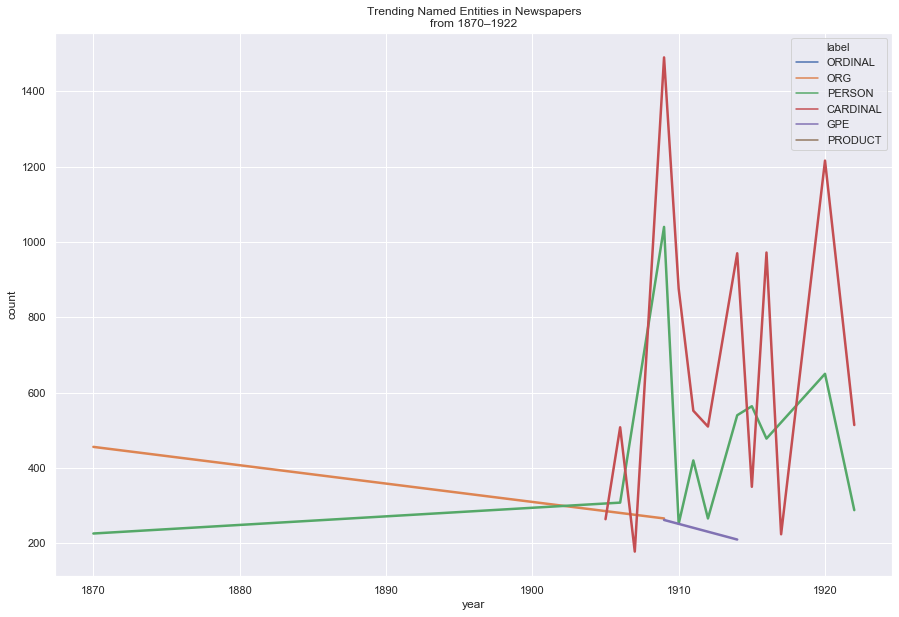

In [114]:
sns.set(rc={'figure.figsize':(15, 10)})

ner_words = ner_df \
    .groupby(['year', 'label'])['count'].sum().reset_index() \
    .query('count >= 150')

ax = sns.lineplot(data = ner_words, x = "year", y = "count", 
                  hue = "label", linewidth = 2.5) \
    .set_title('Trending Named Entities in Newspapers\nfrom ' + \
               str(min(ner_df['year'])) + '–' + str(max(ner_df['year'])))

In [136]:
ner_df \
    .query('(year == 1909) & (label == "PERSON")') \
    .sort_values(by = ['count'], ascending = False) \
    .drop_duplicates()

,state,year,entity,label,count
15050,Missouri,1909,Boyer,PERSON,14.0
20170,Missouri,1909,Walton,PERSON,10.0
13171,Missouri,1909,Ml,PERSON,9.0
2507,Missouri,1909,Robinson,PERSON,8.0
2412,Missouri,1909,Martin,PERSON,8.0
...,...,...,...,...,...
255,Missouri,1909,Ray,PERSON,1.0
272,Missouri,1909,Taylor,PERSON,1.0
278,Missouri,1909,Uncock,PERSON,1.0
289,Missouri,1909,Whltwell,PERSON,1.0
